# Training Curves Viewer

Paste your training folder path below and run all cells to visualize TensorBoard curves.

  ✓ Loaded run 'train' with 12 tags: ['wpb', 'wps', 'lr', 'bsz', 'gb_free', 'gnorm', 'loss_scale', 'wall', 'train_wall', 'ups', 'loss', 'clip']
  ✓ Loaded run 'train_inner' with 12 tags: ['wpb', 'wps', 'lr', 'bsz', 'gb_free', 'gnorm', 'loss_scale', 'wall', 'train_wall', 'ups', 'loss', 'clip']
  ✓ Loaded run 'valid' with 7 tags: ['wpb', 'wps', 'ssim', 'bsz', 'mcd', 'loss', 'best_loss']

📊 Total unique tags: 15
   Tags: ['best_loss', 'bsz', 'clip', 'gb_free', 'gnorm', 'loss', 'loss_scale', 'lr', 'mcd', 'ssim', 'train_wall', 'ups', 'wall', 'wpb', 'wps']

📅 Parsed 909 step→epoch entries from hydra_train.log


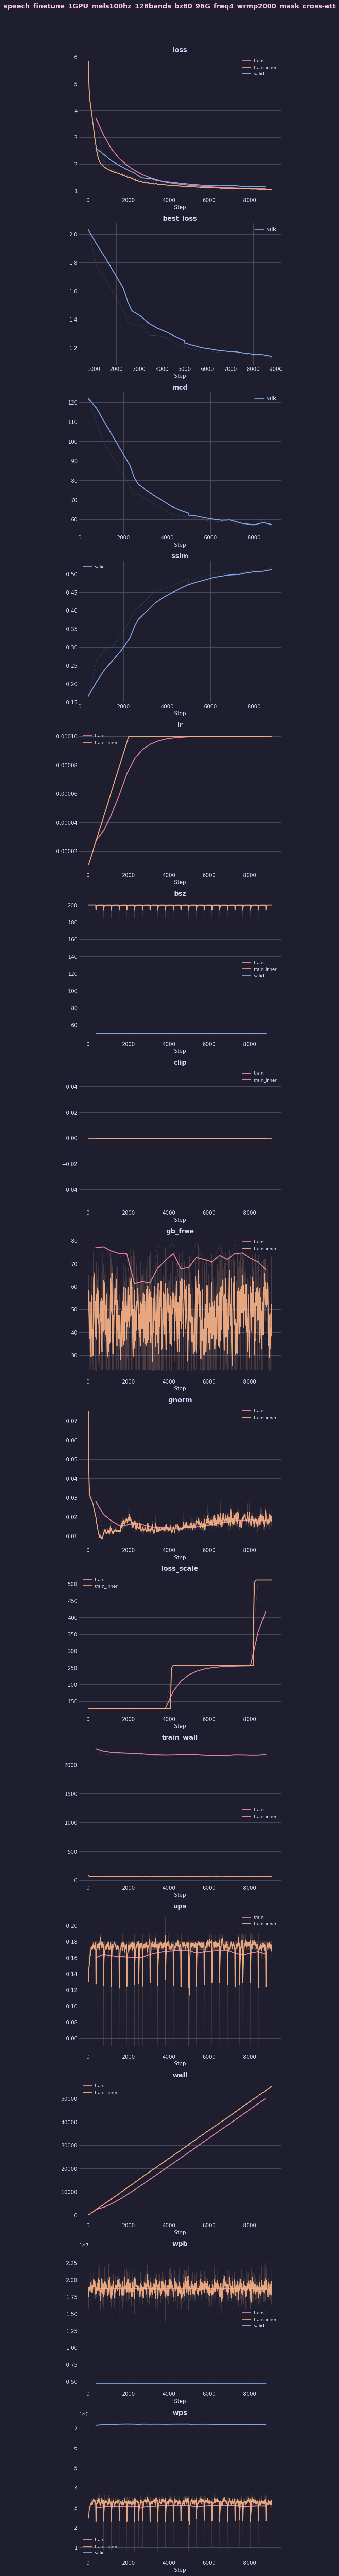

In [ ]:
import os
import json as _json
import re as _re
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# ============================================================
# PASTE YOUR TRAINING FOLDER PATH HERE
# ============================================================
tF="/ceph/home/TUG/olivares-tug/MMS-LLaMA/exp/mms-speech-NoLLM/speech_bz10_4MiG_freq4_wrmp2000_mask_modalitydrop_noise_fiftyfifty"
# ── Configuration ──────────────────────────────────────────────
TB_DIR = os.path.join(tF, "tensorboard")
assert os.path.isdir(TB_DIR), f"TensorBoard directory not found: {TB_DIR}"

# Nice style
plt.style.use('seaborn-v0_8-darkgrid')
matplotlib.rcParams.update({
    'figure.facecolor': '#1e1e2e',
    'axes.facecolor': '#1e1e2e',
    'axes.edgecolor': '#cdd6f4',
    'axes.labelcolor': '#cdd6f4',
    'text.color': '#cdd6f4',
    'xtick.color': '#cdd6f4',
    'ytick.color': '#cdd6f4',
    'grid.color': '#45475a',
    'figure.dpi': 100,
    'font.size': 11,
    'legend.framealpha': 0.3,
})

# Colors for each run
RUN_COLORS = {
    'train': '#f38ba8',
    'train_inner': '#fab387',
    'valid': '#89b4fa',
}

# ── Load all runs ─────────────────────────────────────────────
runs = {}  # run_name -> {tag: (steps, values)}
for run_name in sorted(os.listdir(TB_DIR)):
    run_path = os.path.join(TB_DIR, run_name)
    if not os.path.isdir(run_path):
        continue
    ea = EventAccumulator(run_path)
    ea.Reload()
    scalar_tags = ea.Tags().get('scalars', [])
    if not scalar_tags:
        print(f"  ⚠ No scalar tags found for run '{run_name}'")
        continue
    run_data = {}
    for tag in scalar_tags:
        events = ea.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        run_data[tag] = (steps, values)
    runs[run_name] = run_data
    print(f"  ✓ Loaded run '{run_name}' with {len(scalar_tags)} tags: {scalar_tags}")

# ── Collect all unique tags ──────────────────────────────────
all_tags = set()
for run_data in runs.values():
    all_tags.update(run_data.keys())
all_tags = sorted(all_tags)
print(f"\n📊 Total unique tags: {len(all_tags)}")
print(f"   Tags: {all_tags}")

# ── Parse hydra_train.log for step → epoch mapping ──────────
_log_path = os.path.join(tF, 'hydra_train.log')
_step_epoch_pairs = []  # list of (num_updates, epoch)
if os.path.isfile(_log_path):
    with open(_log_path, 'r') as _f:
        for _line in _f:
            if 'num_updates' in _line and '"epoch"' in _line:
                _m = _re.search(r'\{.*\}', _line)
                if _m:
                    try:
                        _d = _json.loads(_m.group())
                        _step_epoch_pairs.append((int(_d['num_updates']), int(_d['epoch'])))
                    except Exception:
                        pass
    print(f'\n📅 Parsed {len(_step_epoch_pairs)} step→epoch entries from hydra_train.log')
else:
    print(f'\n⚠ hydra_train.log not found at {_log_path}')

# Build interpolation arrays
_step_arr = np.array([p[0] for p in _step_epoch_pairs], dtype=float) if _step_epoch_pairs else np.array([0.0, 1.0])
_epoch_arr = np.array([p[1] for p in _step_epoch_pairs], dtype=float) if _step_epoch_pairs else np.array([0.0, 0.0])

def step_to_epoch(steps):
    return np.interp(steps, _step_arr, _epoch_arr)

def epoch_to_step(epochs):
    # For inverse: use last step per unique epoch
    _ue2, _idx2 = np.unique(_epoch_arr[::-1], return_index=True)
    _idx_last = len(_epoch_arr) - 1 - _idx2
    return np.interp(epochs, _epoch_arr[sorted(_idx_last)], _step_arr[sorted(_idx_last)])

# ── Smoothing utility ────────────────────────────────────────
def smooth(values, weight=0.6):
    """Exponential moving average smoothing (same as TensorBoard)."""
    smoothed = []
    last = values[0] if values else 0
    for v in values:
        s = last * weight + (1 - weight) * v
        smoothed.append(s)
        last = s
    return smoothed

# ── Group tags by category ───────────────────────────────────
# Important metrics first, then the rest
PRIORITY_TAGS = ['loss', 'best_loss', 'mcd', 'ssim', 'lr']
priority_present = [t for t in PRIORITY_TAGS if t in all_tags]
other_tags = [t for t in all_tags if t not in PRIORITY_TAGS]
ordered_tags = priority_present + other_tags

# ── Plot all curves ──────────────────────────────────────────
n_tags = len(ordered_tags)
n_cols = 1
n_rows = (n_tags + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 5 * n_rows))
axes = axes.flatten() if n_tags > 1 else [axes]

for idx, tag in enumerate(ordered_tags):
    ax = axes[idx]
    for run_name, run_data in runs.items():
        if tag not in run_data:
            continue
        steps, values = run_data[tag]
        color = RUN_COLORS.get(run_name, '#a6e3a1')
        # Raw data (faint)
        ax.plot(steps, values, alpha=0.2, color=color, linewidth=0.8)
        # Smoothed data (bold)
        if len(values) > 1:
            ax.plot(steps, smooth(values), alpha=0.9, color=color,
                    linewidth=2, label=run_name)
        else:
            ax.plot(steps, values, alpha=0.9, color=color,
                    linewidth=2, label=run_name, marker='o')
    ax.set_title(tag, fontsize=14, fontweight='bold', color='#cdd6f4')
    ax.set_xlabel('Step')
    ax.legend(loc='best', fontsize=9)

# Hide unused axes
for idx in range(n_tags, len(axes)):
    axes[idx].set_visible(False)

fig.suptitle(
    os.path.basename(tF),
    fontsize=14, fontweight='bold', color='#f5c2e7', y=1.01
)
plt.tight_layout()
plt.show()

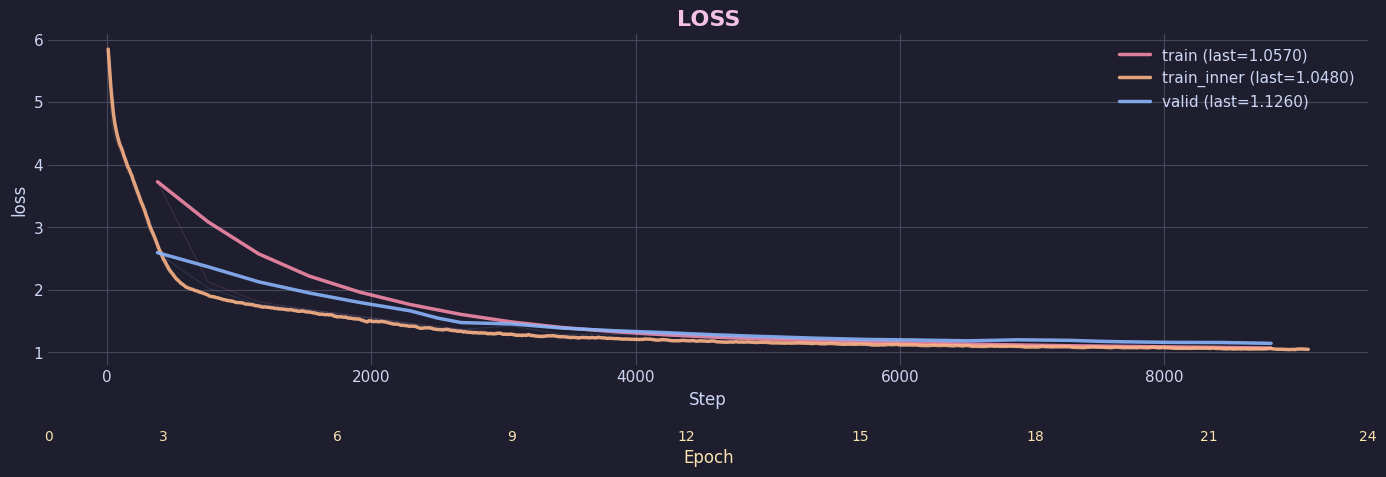

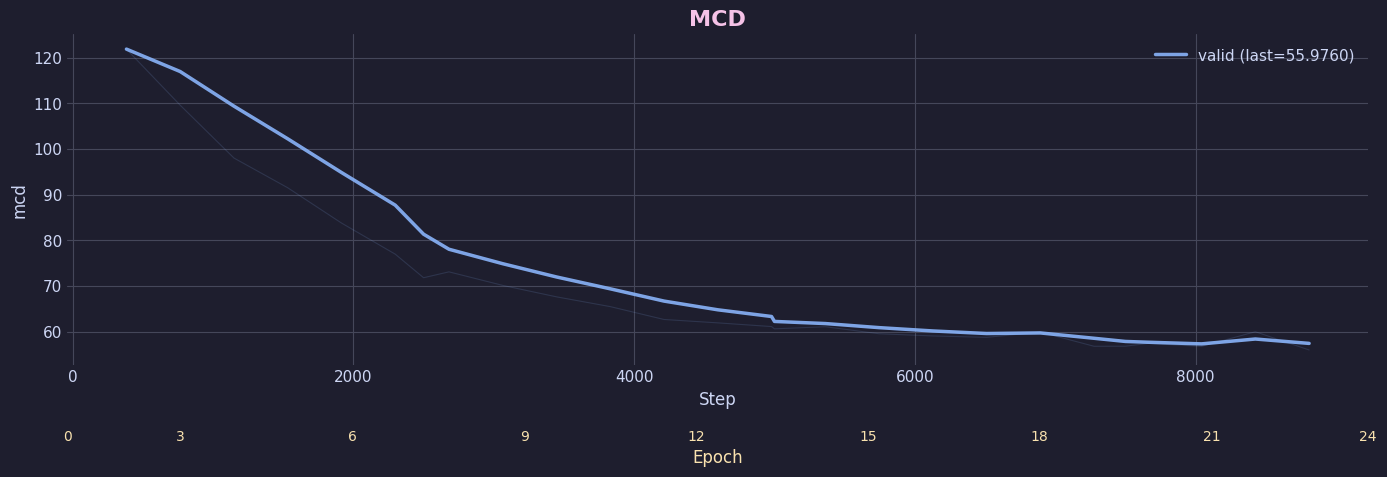

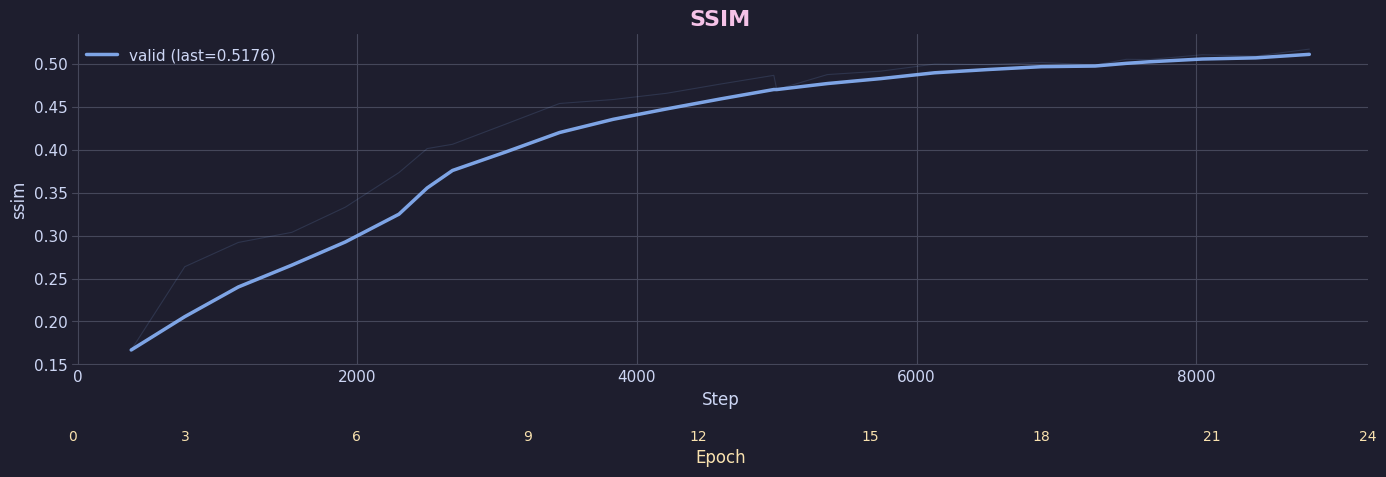

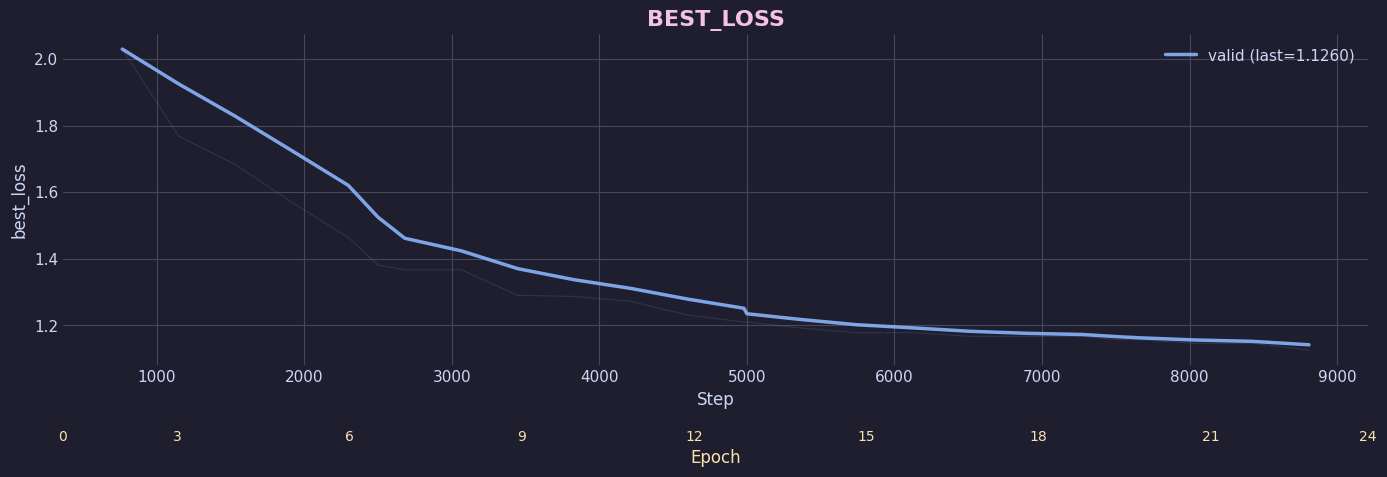

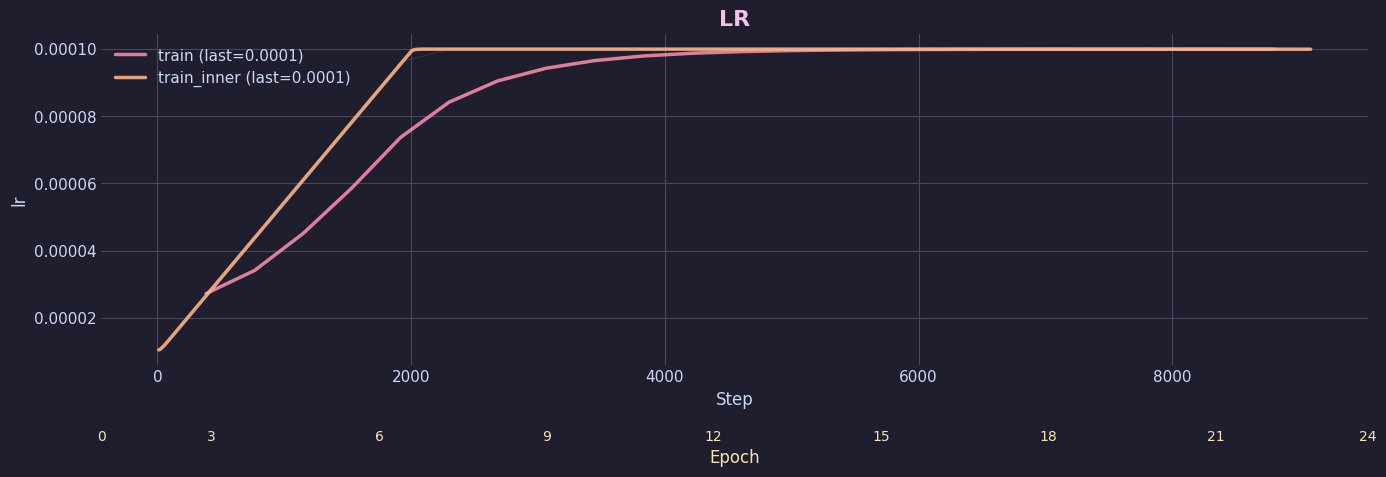

In [2]:
# ── Individual detailed plots for key metrics ────────────────
from matplotlib.ticker import MaxNLocator

KEY_METRICS = ['loss', 'mcd', 'ssim', 'best_loss', 'lr']
key_present = [t for t in KEY_METRICS if t in all_tags]

for tag in key_present:
    fig, ax = plt.subplots(figsize=(14, 5))
    for run_name, run_data in runs.items():
        if tag not in run_data:
            continue
        steps, values = run_data[tag]
        color = RUN_COLORS.get(run_name, '#a6e3a1')
        ax.plot(steps, values, alpha=0.15, color=color, linewidth=0.8)
        if len(values) > 1:
            smoothed = smooth(values)
            ax.plot(steps, smoothed, alpha=0.9, color=color,
                    linewidth=2.5, label=f"{run_name} (last={values[-1]:.4f})")
        else:
            ax.plot(steps, values, alpha=0.9, color=color,
                    linewidth=2.5, label=f"{run_name} ({values[-1]:.4f})", marker='o')
    ax.set_title(tag.upper(), fontsize=16, fontweight='bold', color='#f5c2e7')
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel(tag, fontsize=12)
    ax.legend(loc='best', fontsize=11)

    # ── Secondary x-axis: Epoch ────────────────────────────────
    if len(_step_epoch_pairs) > 0:
        secax = ax.secondary_xaxis(-0.18, functions=(step_to_epoch, epoch_to_step))
        secax.set_xlabel('Epoch', fontsize=12, color='#f9e2af')
        secax.tick_params(colors='#f9e2af', labelsize=10)
        secax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))

    plt.tight_layout()
    plt.show()

In [ ]:
# ── Summary table ────────────────────────────────────────────
print("\n" + "=" * 80)
print(f"  TRAINING SUMMARY: {os.path.basename(tF)}")
print("=" * 80)

for run_name, run_data in runs.items():
    print(f"\n  ── {run_name} " + "─" * (60 - len(run_name)))
    for tag in sorted(run_data.keys()):
        steps, values = run_data[tag]
        if len(values) == 0:
            continue
        last_val = values[-1]
        min_val = min(values)
        max_val = max(values)
        last_step = steps[-1]
        print(f"    {tag:<20s} │ last={last_val:<12.4f} │ min={min_val:<12.4f} │ max={max_val:<12.4f} │ step={last_step}")

print("\n" + "=" * 80)


  TRAINING SUMMARY: speech_finetune_1GPU_mels100hz_128bands_bz20_48G_freq4_wrmp2000_mask_modalitydrop_norm

  ── train ───────────────────────────────────────────────────────
    bsz                  │ last=80.0000      │ min=80.0000      │ max=80.0000      │ step=72650
    clip                 │ last=0.0000       │ min=0.0000       │ max=0.0000       │ step=72650
    gb_free              │ last=27.3000      │ min=16.5000      │ max=84.7000      │ step=72650
    gnorm                │ last=0.0370       │ min=0.0300       │ max=0.0480       │ step=72650
    loss                 │ last=1.2550       │ min=1.2220       │ max=2.7840       │ step=72650
    loss_scale           │ last=32768.0000   │ min=128.0000     │ max=65536.0000   │ step=72650
    lr                   │ last=0.0001       │ min=0.0000       │ max=0.0001       │ step=72650
    train_wall           │ last=3278.0000    │ min=2124.0000    │ max=3423.0000    │ step=72650
    ups                  │ last=0.2500       │ min=0.240